# Data Loading

In [3]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.functions import UserDefinedFunction, col, mean, log1p
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import pandas as pd

import os

"""
Spark session variables declaration and spark initialization
"""

path = os.getcwd()

conf = SparkConf() \
    .setAppName("PostgreSQL Writing to Formatted Table") \
    .set("spark.jars", path+"/../.."+"/driver/postgresql-42.7.3.jar")

spark = SparkSession.builder \
    .config(conf=conf) \
    .getOrCreate()


"""
Connection details for table from formatted zone read
"""

jdbc_url = "jdbc:postgresql://localhost:5432/bda_project1_db"
driver_class = "org.postgresql.Driver"
user = "postgres"
password = "hola123"
connectionProperties = {"user": "postgres", "password": "hola123"}


df = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5432/bda_project1_db") \
    .option("dbtable", "dog_caract_formatted") \
    .option("user", connectionProperties["user"]) \
    .option("password", connectionProperties["password"]) \
    .option("driver", "org.postgresql.Driver") \
    .load()


df.show()

24/04/24 17:02:25 WARN Utils: Your hostname, marcel-compu resolves to a loopback address: 127.0.1.1; using 192.168.1.47 instead (on interface wlp3s0)
24/04/24 17:02:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/04/24 17:02:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/24 17:02:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+--------------------+-----------------+---------------+-------------------+-----------------+---------------+-----------------+---------------+-------------------+-----------------+---------------+--------------------+-----------+--------------+--------+------------+
|barking|coat_length|drooling|energy|good_with_children|good_with_other_dogs|good_with_strangers|grooming|          image_link|max_height_female|max_height_male|max_life_expectancy|max_weight_female|max_weight_male|min_height_female|min_height_male|min_life_expectancy|min_weight_female|min_weight_male|                name|playfulness|protectiveness|shedding|trainability|
+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+--------------------+-----------------+---------------+-------------------+-----------------+---------------+-----------------+---------------+---

# Missings Treatment

In [4]:
total_missings, missing_cols = 0, []
for name, dtype in df.dtypes:
    try:
        if dtype == 'string':
            filtered_df = df.filter(col(name) == "n/a")
        elif dtype == 'bigint':
            filtered_df = df.filter(col(name) == 101)
        else:
            continue
        class_count = filtered_df.groupBy(name).count()
        number_of_missings = class_count.first()["count"]
        missing_cols.append(name)
        total_missings += number_of_missings
    except TypeError:
        print(f"No Missing Values found on variable {name}")

No Missing Values found on variable barking
No Missing Values found on variable coat_length
No Missing Values found on variable drooling
No Missing Values found on variable energy
No Missing Values found on variable good_with_children
No Missing Values found on variable good_with_other_dogs
No Missing Values found on variable good_with_strangers
No Missing Values found on variable grooming
No Missing Values found on variable image_link
No Missing Values found on variable name
No Missing Values found on variable playfulness
No Missing Values found on variable protectiveness
No Missing Values found on variable shedding
No Missing Values found on variable trainability


In [5]:
print("Total Number of Rows before missings removal:", df.count())
missings_percentage = (total_missings/df.count())*100
print("Percentage of Missings over whole dataset:",missings_percentage)
for name, data_type in df.dtypes:
    if missings_percentage > 10: # If more than 10% of data contains missings a missing imputation method is used
        
            if name in missing_cols:
                if data_type == 'string':

                    # Mode extraction
                    grouped_df = df.groupBy(col(name))

                    value_counts = grouped_df.count()

                    sorted_counts = value_counts.orderBy(col('count').desc())

                    # We need to count again the missings from the column to know if the most common value is a missing
                    filtered_df = df.filter(col("classification") == "n/a")
                    class_count = filtered_df.groupBy('classification').count()
                    number_of_missings = class_count.first()["count"]

                    if number_of_missings/df.count() < 0.5: # If the missing value is more than half, the second most common value will be taken as the first will be the missing value
                        most_common_value = sorted_counts.first()[name]
                    else:
                        most_common_value = sorted_counts.rdd.skip(1).take(1)[0][name]

                    udf = UserDefinedFunction(lambda x: most_common_value if x=="n/a" else x, data_type)

                    df = df.select(*[udf(column).alias(name) if column == name else column for column in df.columns])
                
                elif data_type == 'int':
                    # Mean Extraction
                    mean_value = df.select(mean(col(name))).first()[0]

                    udf = UserDefinedFunction(lambda x: mean_value if x==101 else x, data_type)

                    df = df.select(*[udf(column).alias(name) if column == name else column for column in df.columns])
        
    else: # If missings do not take more than 10% of data it is deemed safe to remove them
        if data_type == 'string':
            df = df.filter(col(name) != "n/a")

        elif data_type == 'int':
            df = df.filter(col(name) != 101)

print("Total Number of Rows after missings removal:", df.count())

Total Number of Rows before missings removal: 1104
Percentage of Missings over whole dataset: 0.0
Total Number of Rows after missings removal: 1104


# Correlations Study

In [6]:
vector_col = "corr_features"
numeric_variables = [column for column, dtype in df.dtypes if dtype == "bigint" or dtype == "double"]
assembler = VectorAssembler(inputCols=numeric_variables, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, 'corr_features').collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = numeric_variables, index=numeric_variables) 
corr_matrix_df.style.background_gradient(cmap='coolwarm').set_precision(2)

/tmp/ipykernel_37105/803626345.py:10: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_matrix_df.style.background_gradient(cmap='coolwarm').set_precision(2)


,barking,coat_length,drooling,energy,good_with_children,good_with_other_dogs,good_with_strangers,grooming,max_height_female,max_height_male,max_life_expectancy,max_weight_female,max_weight_male,min_height_female,min_height_male,min_life_expectancy,min_weight_female,min_weight_male,playfulness,protectiveness,shedding,trainability
barking,1.00,0.12,-0.21,0.21,0.13,0.13,0.16,0.14,-0.32,-0.32,-0.11,-0.33,-0.34,-0.30,-0.31,-0.11,-0.32,-0.32,0.24,-0.05,-0.02,0.09
coat_length,0.12,1.00,-0.07,-0.13,-0.08,0.00,0.01,0.12,-0.11,-0.11,-0.01,-0.07,-0.08,-0.11,-0.11,-0.01,-0.08,-0.09,-0.03,-0.02,-0.10,-0.04
drooling,-0.21,-0.07,1.00,-0.18,0.01,-0.08,-0.04,-0.04,0.46,0.46,-0.00,0.64,0.65,0.45,0.46,-0.00,0.66,0.64,-0.11,0.32,0.28,0.04
energy,0.21,-0.13,-0.18,1.00,0.18,0.18,0.19,-0.12,0.07,0.06,0.02,-0.15,-0.17,0.07,0.06,0.02,-0.15,-0.16,0.37,-0.05,0.13,0.32
good_with_children,0.13,-0.08,0.01,0.18,1.00,0.39,0.36,0.10,-0.08,-0.09,0.01,-0.08,-0.07,-0.06,-0.07,0.01,-0.09,-0.08,0.34,-0.19,0.03,0.24
good_with_other_dogs,0.13,0.00,-0.08,0.18,0.39,1.00,0.27,-0.05,-0.09,-0.09,-0.03,-0.21,-0.21,-0.10,-0.10,-0.03,-0.17,-0.18,0.22,-0.39,0.03,0.11
good_with_strangers,0.16,0.01,-0.04,0.19,0.36,0.27,1.00,0.16,-0.23,-0.24,-0.02,-0.27,-0.26,-0.20,-0.20,-0.02,-0.23,-0.21,0.59,-0.07,0.05,0.24
grooming,0.14,0.12,-0.04,-0.12,0.10,-0.05,0.16,1.00,-0.23,-0.23,-0.07,-0.15,-0.13,-0.20,-0.19,-0.07,-0.16,-0.14,0.20,0.13,-0.19,0.01
max_height_female,-0.32,-0.11,0.46,0.07,-0.08,-0.09,-0.23,-0.23,1.00,1.00,-0.01,0.80,0.82,0.97,0.97,-0.01,0.82,0.81,-0.28,0.13,0.30,0.04
max_height_male,-0.32,-0.11,0.46,0.06,-0.09,-0.09,-0.24,-0.23,1.00,1.00,-0.01,0.81,0.83,0.96,0.97,-0.01,0.82,0.82,-0.29,0.13,0.30,0.04


In [7]:
# As supposed, complementary variables with maximum and minimums are greatly correlated so the average could be used instead of a pair of maximum and minimum
pairs,i = [], 0
for row in corr_matrix:
    j = 0
    for cell in row:
        if cell > 0.8 and (numeric_variables[j],numeric_variables[i]) not in pairs and numeric_variables[j] != numeric_variables[i]:
            if numeric_variables[i].split("_")[2] == numeric_variables[j].split("_")[2] and numeric_variables[i].split("_")[1] == numeric_variables[j].split("_")[1]:
                pairs.append((numeric_variables[i],numeric_variables[j]))
        j += 1
    i += 1
pairs

[('max_height_female', 'min_height_female'),
 ('max_height_male', 'min_height_male'),
 ('max_life_expectancy', 'min_life_expectancy'),
 ('max_weight_female', 'min_weight_female'),
 ('max_weight_male', 'min_weight_male')]

In [8]:
pair = pairs[0]
"avg_"+"_".join(pair[0].split("_")[1:])

'avg_height_female'

In [9]:
for pair in pairs:

    marksColumns = [col(pair[0]), col(pair[1])]

    averageFunc = sum(x for x in marksColumns)/len(marksColumns)

    df = df.withColumn("avg_"+"_".join(pair[0].split("_")[1:]), averageFunc)

    df = df.drop(pair[0])
    df = df.drop(pair[1])

df.show()

+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+--------------------+--------------------+-----------+--------------+--------+------------+-----------------+---------------+-------------------+-----------------+---------------+
|barking|coat_length|drooling|energy|good_with_children|good_with_other_dogs|good_with_strangers|grooming|          image_link|                name|playfulness|protectiveness|shedding|trainability|avg_height_female|avg_height_male|avg_life_expectancy|avg_weight_female|avg_weight_male|
+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+--------------------+--------------------+-----------+--------------+--------+------------+-----------------+---------------+-------------------+-----------------+---------------+
|      1|          1|       0|     0|                 3|                   3|                  0|       0|https://api-ninja...|    American Bu

# Data Distribution Visualization

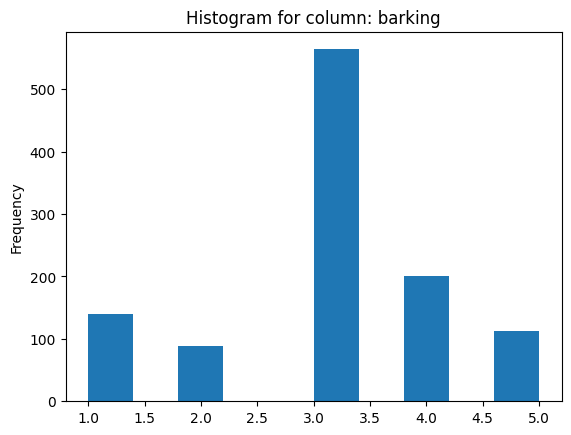

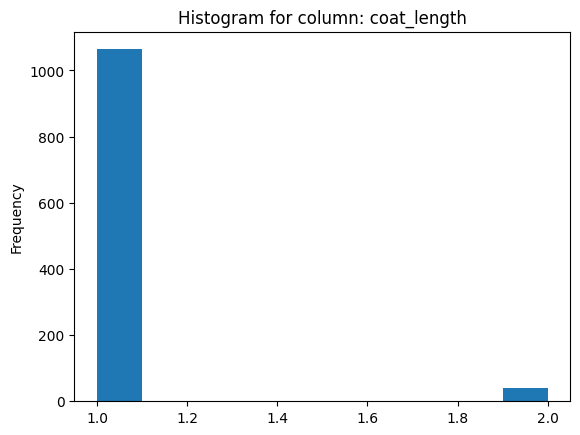

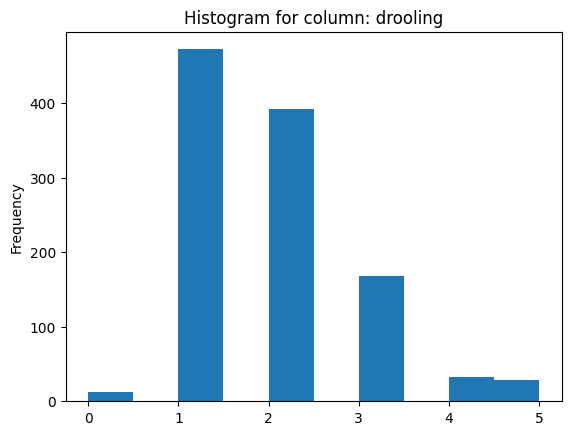

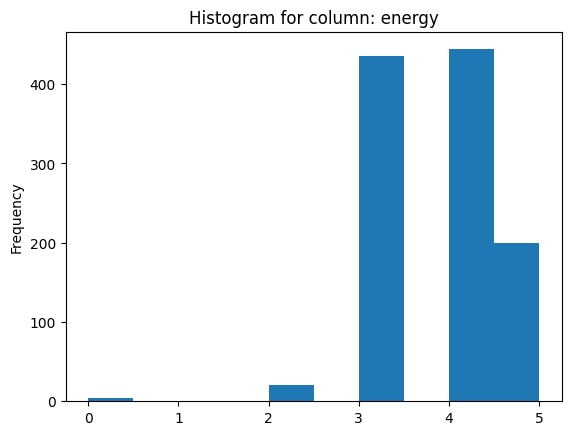

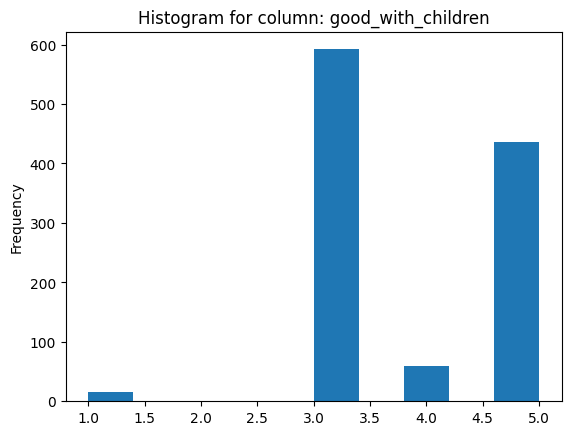

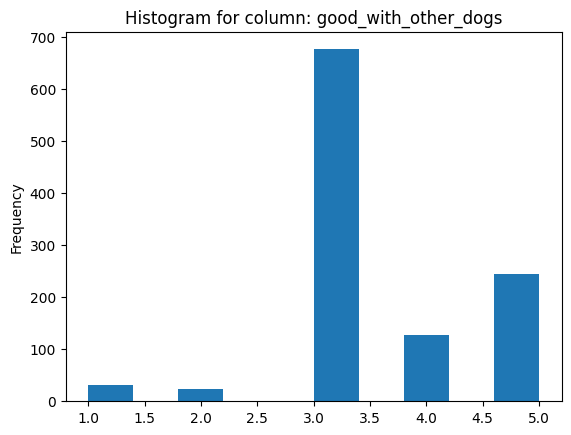

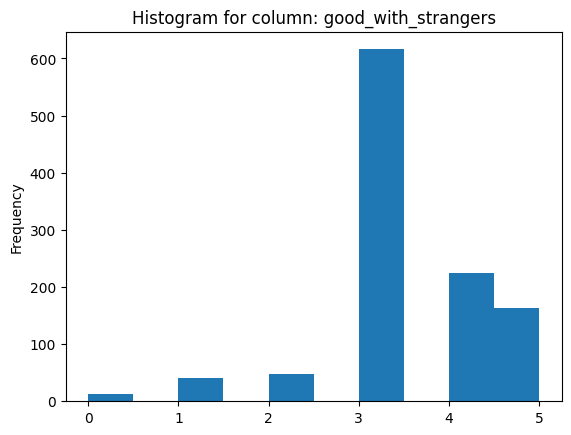

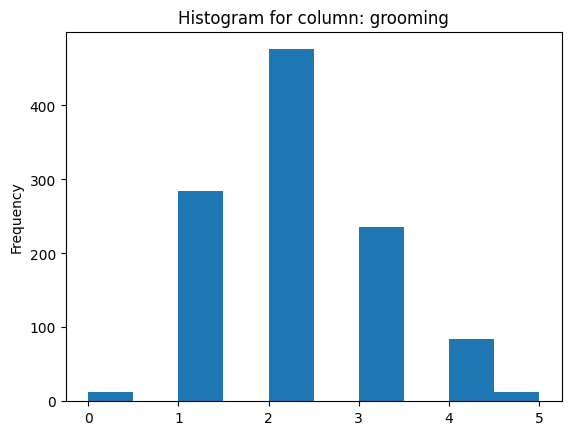

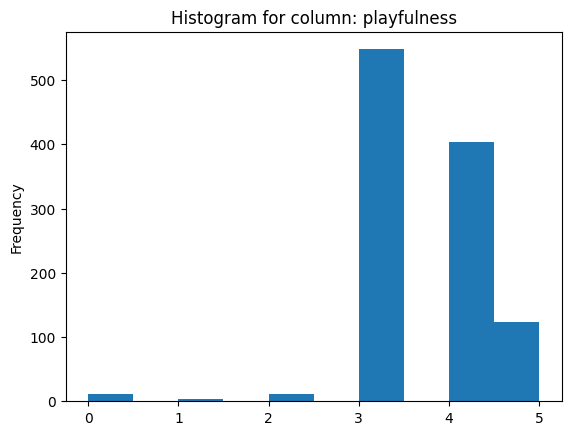

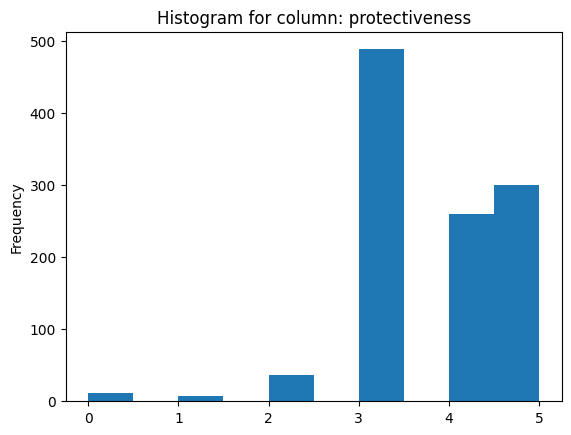

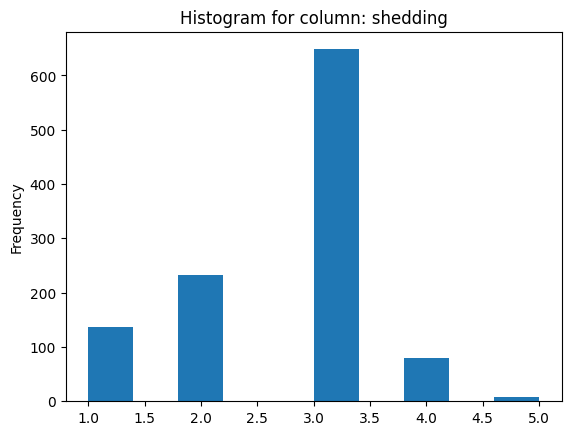

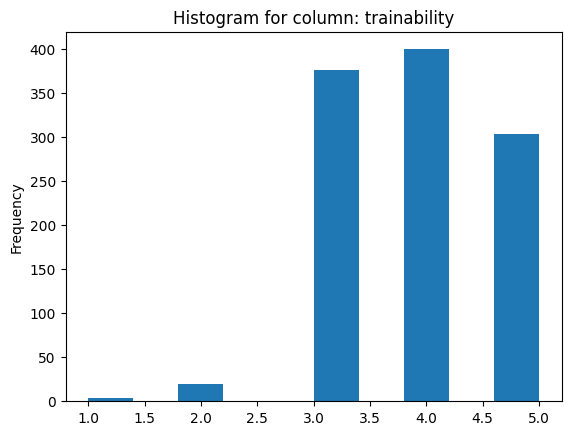

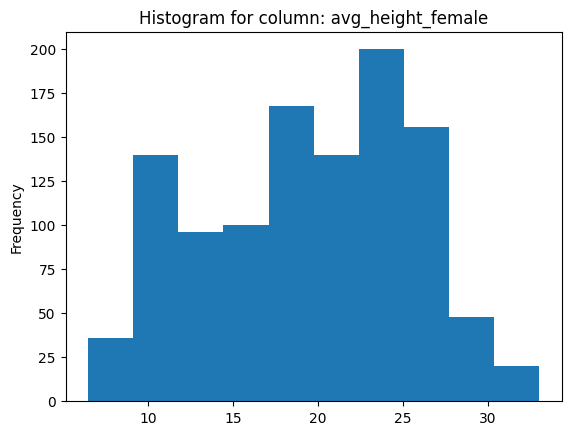

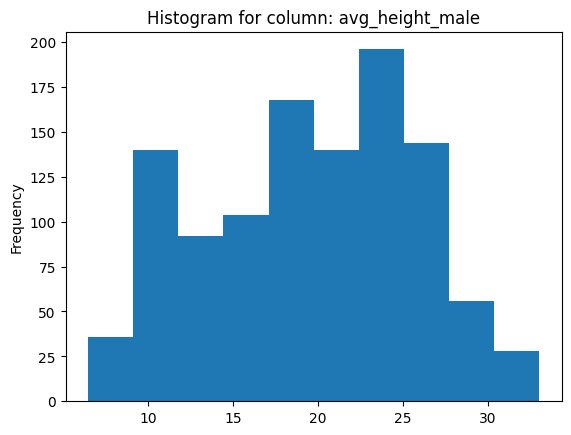

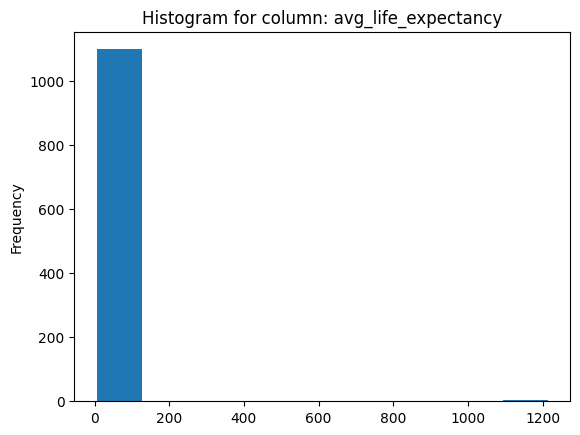

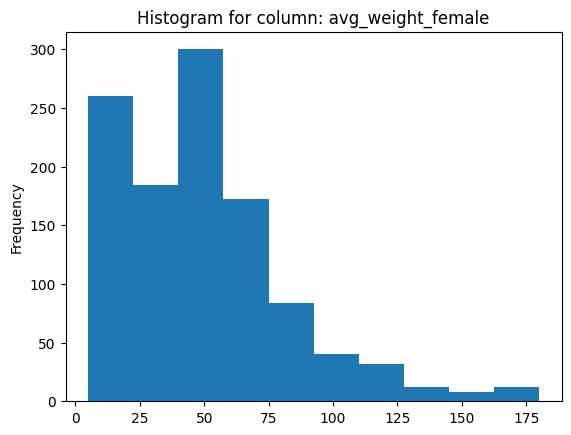

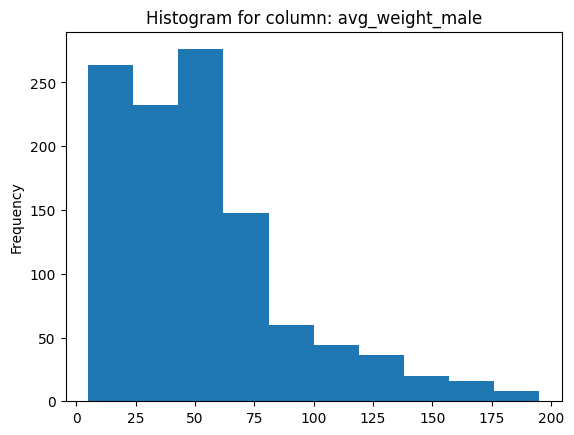

In [11]:
numeric_variables = [column for column, dtype in df.dtypes if dtype == "bigint" or dtype == "double"]
for col in numeric_variables:
  df_pandas = df.toPandas()  # Convert to pandas DataFrame
  df_pandas[col].plot.hist()
  plt.title(f"Histogram for column: {col}")
  plt.show()

We find that distributions with few values are somewhat eskewd to a left or right side whereas other distributions resemble a normal distribution while average weight follows what seems an exponential distribution and could be normalized or some outliers could be removed

In [ ]:
cols_to_normalize = []
for col_name in cols_to_normalize:
    

    # Assuming you have your PySpark DataFrame (`df`) and the column to normalize (`col_to_normalize`)

    normalized_col = log1p(col(col_name))
    df = df.withColumn(col_name + "_log_normalized", normalized_col)
    df = df.drop(col_name)
